In [706]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [707]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [708]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

In [709]:
class DirichletBc:
    """Class defining a Dirichlet boundary condition"""
    
    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        return self._value
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 0
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

In [710]:
class NeumannBc:
    """Class defining a Neumann boundary condition"""
    
    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

In [711]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs
    

In [712]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [713]:
import numpy as np
from numpy.linalg import norm
# Problem1
# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 8
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 100
converged = 1e-6

# Define thermophysical properties
k = 60

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 373

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 273, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

Iteration = 0; Max. Resid. = 23.99999999999998; Avg. Resid. = 2.9999999999999973
[373.   366.75 354.25 341.75 329.25 316.75 304.25 291.75 279.25 273.  ]
Iteration = 1; Max. Resid. = 3.3306690738754696e-15; Avg. Resid. = 1.304512053934559e-15


In [714]:

#txt_file = open("GridTest.txt","a")

# Append new line
#txt_file.write('\n')

# Append your variables
#txt_file.write('ncv=' + str(ncv) + " T =" + str(T) + '\n')

# Close file
#txt_file.close()
# Storing The T values
#save_Tsolns.extend(T_solns)
#print(save_Tsolns)
#save_Tsolns = []

No handles with labels found to put in legend.


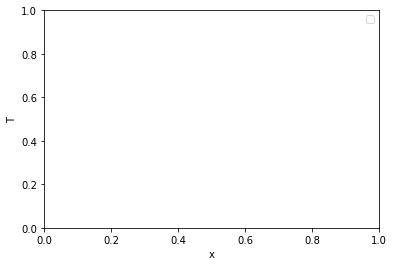

In [715]:

%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in save_Tsolns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()



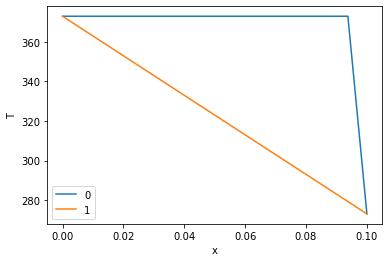

In [716]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [717]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To
        
      
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)
        
        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs
    

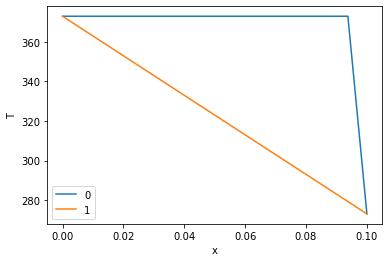

In [718]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [719]:
# Problem 2
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 64
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
ho = 12
To = 298

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 373, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceConvection = SurfaceConvectionModel(grid, T, ho, To)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceConvection.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

Iteration = 0; Max. Resid. = 140.1592500000005; Avg. Resid. = 4.380703125000009
[373.         372.58516872 371.78464098 371.01293537 370.26975044
 369.55479588 368.86779241 368.20847167 367.57657612 366.97185891
 366.39408384 365.84302521 365.31846776 364.82020658 364.34804705
 363.90180473 363.4813053  363.0863845  362.71688807 362.37267168
 362.05360086 361.75955097 361.49040717 361.2460643  361.02642693
 360.83140925 360.6609351  360.51493787 360.39336054 360.29615562
 360.22328513 360.17472061 360.1504431  360.1504431  360.17472061
 360.22328513 360.29615562 360.39336054 360.51493787 360.6609351
 360.83140925 361.02642693 361.2460643  361.49040717 361.75955097
 362.05360086 362.37267168 362.71688807 363.0863845  363.4813053
 363.90180473 364.34804705 364.82020658 365.31846776 365.84302521
 366.39408384 366.97185891 367.57657612 368.20847167 368.86779241
 369.55479588 370.26975044 371.01293537 371.78464098 372.58516872
 373.        ]
Iteration = 1; Max. Resid. = 7.031875082219585e-1

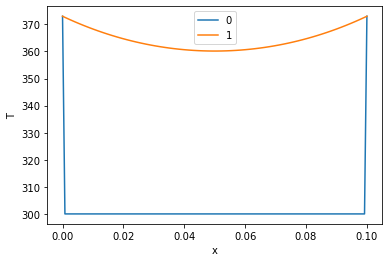

In [720]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [721]:
class RobinBc:
    """Class defining a Neumann boundary condition"""
    
    def __init__(self, phi, grid, T_inf, loc, h, k):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._T_inf = T_inf
        self._h = h
        self._k = k
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + (self._grid.dx_WP[0]*(self._h / self._k)*self._T_inf)) / (1 + self._grid.dx_WP[0]*(self._h / self._k))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] - (self._grid.dx_PE[-1]*(self._h / self._k)*self._T_inf)) / (1 + self._grid.dx_PE[-1]*(self._h / self._k))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        return 1
    
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + (self._grid.dx_WP[0]*(self._h/self._k)*self._T_inf))/(1 + self._grid.dx_WP[0]*(self._h/self._k))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] - (self._grid.dx_PE[-1]*(self._h/self._k)*self._T_inf))/(1 + self._grid.dx_PE[-1]*(self._h/self._k))
        else:
            raise ValueError("Unknown boundary location")

In [722]:
class HeatGenerationModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, q, h):
        """Constructor"""
        self._grid = grid
        self._h = h
       # self._vol = vol
        #self._ncv = ncv
        #dx = lx/float(ncv)
        #self._vol = dx*ly*lz*np.ones(ncv)
        self._q = q
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculating the source term SpVp with a negative sign to subtract it.
        source = - self._q*self._grid.vol
        #print(source)
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [723]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 1
lz = 1
ncv = 32

grid = Grid(lx, ly, lz, ncv)


# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 26

# Define convection parameters
h = 280
q = 50000

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 300

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Added DiricheltBc at East and West Boundary Location at T = 373K
# Define boundary conditions
west_bc = RobinBc(T, grid, 323, BoundaryLocation.WEST, 280, 26)
east_bc = RobinBc(T, grid, 313, BoundaryLocation.EAST, 280, 26)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
HeatGeneration = HeatGenerationModel(grid, q, h)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = HeatGeneration.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))

Iteration = 0; Max. Resid. = 168643.37174940805; Avg. Resid. = 5619.392176418381
Iteration = 1; Max. Resid. = 5.867792959494356e+18; Avg. Resid. = 3.6673705996840915e+17
Iteration = 2; Max. Resid. = 4.373128399552116e+32; Avg. Resid. = 2.733205249720239e+31
Iteration = 3; Max. Resid. = 3.259189976705889e+46; Avg. Resid. = 2.036993735441236e+45
Iteration = 4; Max. Resid. = 2.428997809748297e+60; Avg. Resid. = 1.5181236310927413e+59
Iteration = 5; Max. Resid. = 1.8102750689376026e+74; Avg. Resid. = 1.1314219180860406e+73
Iteration = 6; Max. Resid. = 1.3491555291096082e+88; Avg. Resid. = 8.43222205693511e+86
Iteration = 7; Max. Resid. = 1.0054939566699473e+102; Avg. Resid. = 6.284337229187337e+100
Iteration = 8; Max. Resid. = 7.493710510655675e+115; Avg. Resid. = 4.683569069160002e+114
Iteration = 9; Max. Resid. = 5.584886596781797e+129; Avg. Resid. = 3.490554122988705e+128
Iteration = 10; Max. Resid. = 4.1622849260805e+143; Avg. Resid. = 2.601428078800396e+142
Iteration = 11; Max. Resid.

<ipython-input-711-248c85999bfe>:16: RuntimeWarning: overflow encountered in true_divide
  flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
<ipython-input-711-248c85999bfe>:17: RuntimeWarning: overflow encountered in true_divide
  flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE


Iteration = 195; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 196; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 197; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 198; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 199; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 200; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 201; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 202; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 203; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 204; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 205; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 206; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 207; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 208; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 209; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 210; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 211; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 212; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 213; Max. Resid.

Iteration = 396; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 397; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 398; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 399; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 400; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 401; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 402; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 403; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 404; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 405; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 406; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 407; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 408; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 409; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 410; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 411; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 412; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 413; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 414; Max. Resid.

Iteration = 603; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 604; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 605; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 606; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 607; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 608; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 609; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 610; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 611; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 612; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 613; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 614; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 615; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 616; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 617; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 618; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 619; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 620; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 621; Max. Resid.

Iteration = 815; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 816; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 817; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 818; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 819; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 820; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 821; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 822; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 823; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 824; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 825; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 826; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 827; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 828; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 829; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 830; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 831; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 832; Max. Resid. = nan; Avg. Resid. = nan
Iteration = 833; Max. Resid.

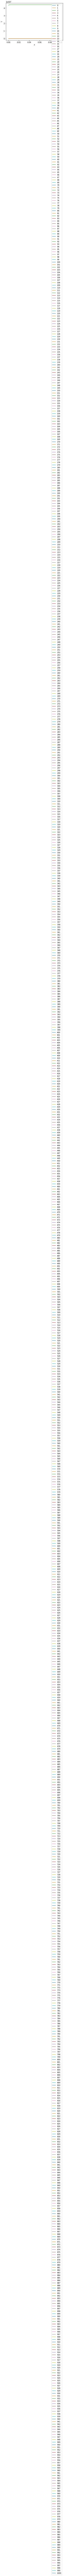

In [724]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()

In [742]:
# Problem 4
class SurfaceRadiationModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid, T, Tc, epi, sigma):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._epi = epi
        self._Tc = Tc
        self._sigma = sigma
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = self._epi*self._sigma*((self._T[1:-1])**4 - (self._Tc)**4)*self._grid.vol
        print(source)
        
        # Calculate the linearization coefficients
        coeffP = 0
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [743]:
import numpy as np
from numpy.linalg import norm

# Define the grid
lx = 0.1
ly = 0.005
lz = 0.005
ncv = 32
grid = Grid(lx, ly, lz, ncv)

# Set the maximum number of iterations and convergence criterion
maxIter = 1000
converged = 1e-6

# Define thermophysical properties
k = 60

# Define convection parameters
h = 0
epi = 1
sigma = 5.67e-8
Tc = 0

# Define the coefficients
coeffs = ScalarCoeffs(grid.ncv)

# Initial conditions
T0 = 273

# Initialize field variable arrays
T = T0*np.ones(grid.ncv+2)

# Define boundary conditions
west_bc = DirichletBc(T, grid, 373, BoundaryLocation.WEST)
east_bc = DirichletBc(T, grid, 0, BoundaryLocation.EAST)

# Apply boundary conditions
west_bc.apply()
east_bc.apply()

# Create list to store the solutions at each iteration
T_solns = [np.copy(T)]

# Define the diffusion model
diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

# Define the surface convection model
surfaceRadiation = SurfaceRadiationModel(grid, T, Tc, epi, sigma)

# Iterate until the solution is converged
for i in range(maxIter):
    # Zero the coefficients and add each influence
    coeffs.zero()
    coeffs = diffusion.add(coeffs)
    coeffs = surfaceRadiation.add(coeffs)

    # Compute residual and check for convergence 
    maxResid = norm(coeffs.rP, np.inf)
    avgResid = np.mean(np.absolute(coeffs.rP))
    print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
    if maxResid < converged:
        break
    
    # Solve the sparse matrix system
    dT = solve(coeffs)
    
    # Update the solution and boundary conditions
    T[1:-1] += dT
    west_bc.apply()
    east_bc.apply()
    
    # Store the solution
    T_solns.append(np.copy(T))
    print(T)

[2.46050175e-05 2.46050175e-05 2.46050175e-05 2.46050175e-05
 2.46050175e-05 2.46050175e-05 2.46050175e-05 2.46050175e-05
 2.46050175e-05 2.46050175e-05 2.46050175e-05 2.46050175e-05
 2.46050175e-05 2.46050175e-05 2.46050175e-05 2.46050175e-05
 2.46050175e-05 2.46050175e-05 2.46050175e-05 2.46050175e-05
 2.46050175e-05 2.46050175e-05 2.46050175e-05 2.46050175e-05
 2.46050175e-05 2.46050175e-05 2.46050175e-05 2.46050175e-05
 2.46050175e-05 2.46050175e-05 2.46050175e-05 2.46050175e-05]
Iteration = 0; Max. Resid. = 262.0800246050184; Avg. Resid. = 11.190023067203892
[373.         367.17146492 355.51444601 343.85747836 332.20056198
 320.54369685 308.88688299 297.23012038 285.57340904 273.91674895
 262.26014013 250.60358257 238.94707627 227.29062122 215.63421744
 203.97786492 192.32156366 180.66531366 169.00911492 157.35296744
 145.69687122 134.04082627 122.38483257 110.72889013  99.07299895
  87.41715904  75.76137038  64.10563299  52.44994685  40.79431198
  29.13872836  17.48319601   5.827

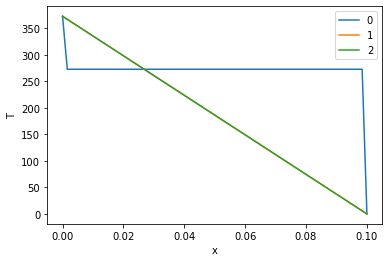

In [744]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for T in T_solns:
    plt.plot(grid.xP, T, label=str(i))
    i += 1

plt.xlabel("x")
plt.ylabel("T")
plt.legend()
plt.show()